# **Kelompok 7 - Kubis Image Detection**

- 12S21029 Mutiara Teccalonica Simanjuntak
- 12S21034 Lasni Sinta Uli Simanjuntak
- 12S21035 Silviana Siagian
- 12S21060 Glory Natasya Hutahaean

# **Business Understanding**

Proyek deteksi kesehatan tanaman ini bertujuan untuk mengembangkan aplikasi berbasis analisis gambar yang dapat mengidentifikasi area sehat dan tidak sehat pada tanaman melalui segmentasi warna daun dan pola visual lainnya. Dengan aplikasi ini, pengguna seperti mahasiswa dan petani dapat mendeteksi masalah kesehatan tanaman, seperti kekurangan nutrisi atau penyakit, secara cepat dan efisien. Aplikasi ini menggunakan teknik segmentasi sederhana berbasis Convolutional Neural Network (CNN), di mana area sehat ditampilkan dalam warna hijau dan area bermasalah ditandai dengan warna kuning atau merah. Solusi ini diharapkan mampu membantu optimalisasi pemantauan dan pemeliharaan kesehatan tanaman, sekaligus menyediakan sarana pembelajaran bagi mahasiswa untuk memahami penerapan machine learning dalam sektor pertanian.

# **Data Understanding**

In [1]:
from google.colab import drive
import os
import cv2
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

# Path ke folder Google Drive
google_drive_folder = '/content/drive/MyDrive/Kubis_Final/train'
dataset_path = '/content/drive/MyDrive/Kubis_Final/train/_annotations.csv'

# Load dataset
import pandas as pd
dataset = pd.read_csv(dataset_path)

# Periksa struktur dataset
print("Kolom Dataset:", dataset.columns)
print("Distribusi Kelas:\n", dataset['class'].value_counts())


Kolom Dataset: Index(['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax'], dtype='object')
Distribusi Kelas:
 class
Kubis Sehat          2002
Kubis Tidak Sehat     566
Bukan Kubis            75
Name: count, dtype: int64


# **Data Preparation**

# **Augmentation**

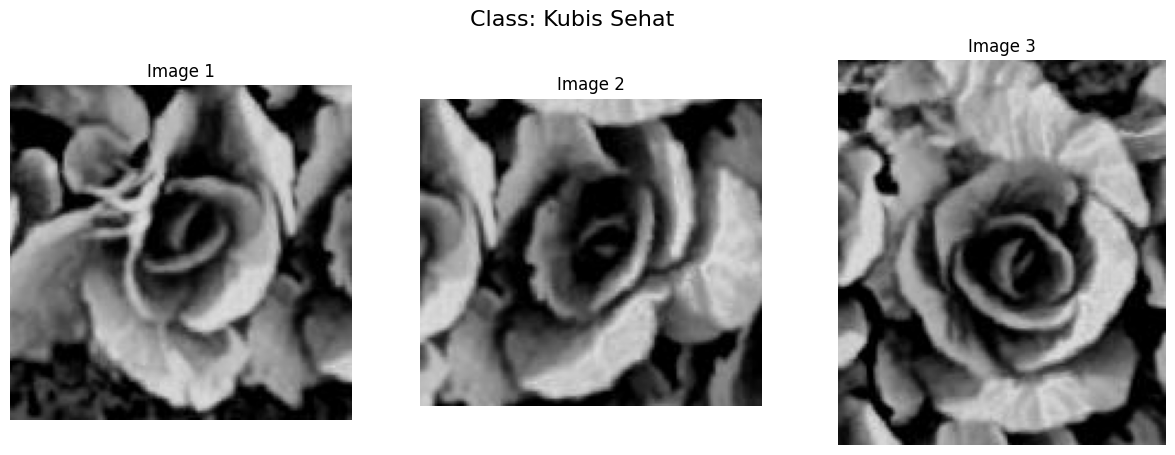

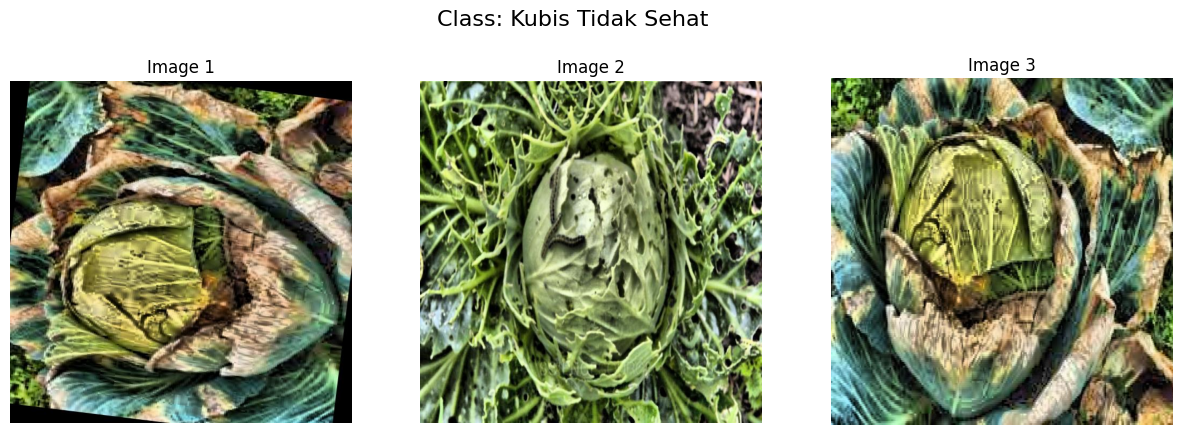

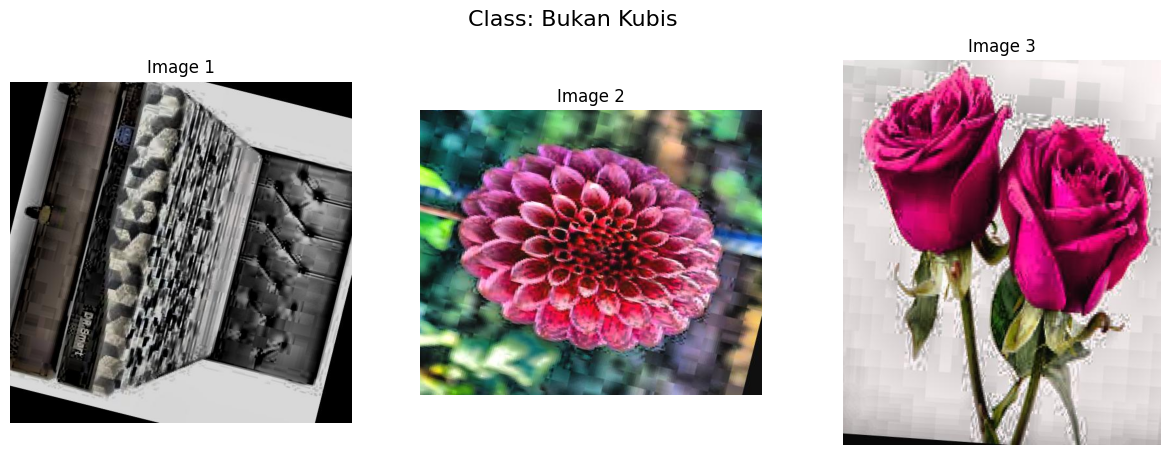

In [3]:

def display_images_by_class(dataset, image_folder, classes, num_images=3):
    for cls in classes:
        # Filter data untuk kelas tertentu
        filtered_data = dataset[dataset['class'] == cls].head(num_images)
        plt.figure(figsize=(15, 5))
        plt.suptitle(f"Class: {cls}", fontsize=16)

        for i, row in enumerate(filtered_data.itertuples(), start=1):
            image_path = os.path.join(image_folder, row.filename)
            if os.path.exists(image_path):
                # Load dan potong gambar sesuai bounding box
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                cropped_image = image[row.ymin:row.ymax, row.xmin:row.xmax]

                # Tampilkan gambar
                plt.subplot(1, num_images, i)
                plt.imshow(cropped_image)
                plt.axis('off')
                plt.title(f"Image {i}")
            else:
                print(f"File not found: {image_path}")

        plt.show()

# Classes to display
classes_to_display = ['Kubis Sehat', 'Kubis Tidak Sehat', 'Bukan Kubis']

# Tampilkan gambar perwakilan
display_images_by_class(dataset, google_drive_folder, classes_to_display)

## **Preprocessing**

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Split dataset untuk training dan validasi
train_data, val_data = train_test_split(dataset, test_size=0.2, stratify=dataset['class'], random_state=42)

# Data augmentation dan preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.2
)

# Generator untuk training
train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=google_drive_folder,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Generator untuk validasi
val_generator = datagen.flow_from_dataframe(
    dataframe=val_data,
    directory=google_drive_folder,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 2114 validated image filenames belonging to 3 classes.
Found 529 validated image filenames belonging to 3 classes.


## **Simpan Informasi Label**

In [4]:
# Label Mapping
label_map = train_generator.class_indices
label_map = {v: k for k, v in label_map.items()}  # Balikkan mapping
print(f"Mapping Label: {label_map}")


Mapping Label: {0: 'Bukan Kubis', 1: 'Kubis Sehat', 2: 'Kubis Tidak Sehat'}


# **Modelling**

## **CNN**

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Definisi model CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 kelas output
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Tampilkan arsitektur model
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

## **Melatih Model**

In [6]:
# Latih model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Sesuaikan jumlah epoch
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.7162 - loss: 0.8211 - val_accuracy: 0.7598 - val_loss: 0.5479
Epoch 2/10
 1/66 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.7500 - loss: 0.5476

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7500 - loss: 0.5476 - val_accuracy: 0.8235 - val_loss: 0.4707
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 80s 617ms/step - accuracy: 0.8631 - loss: 0.3478 - val_accuracy: 0.9648 - val_loss: 0.1260
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0834 - val_accuracy: 1.0000 - val_loss: 0.0402
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 46s 630ms/step - accuracy: 0.9484 - loss: 0.1307 - val_accuracy: 0.9531 - val_loss: 0.1290
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9375 - loss: 0.0697 - val_accuracy: 1.0000 - val_loss: 0.0079
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 80s 624ms/step - accuracy: 0.9397 - loss: 0.2042 - val_accuracy: 0.9746 - val_loss: 0.1042
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9688 - loss: 0.0520 - val_accuracy: 1.0000 - val_loss: 0.0043
Epoch 9/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 82s 637ms/step - accuracy: 0.9859 - loss: 0.0505 - val_accuracy: 0.9902 - val_los

## **Visualisasi Hasil Pelatihan**

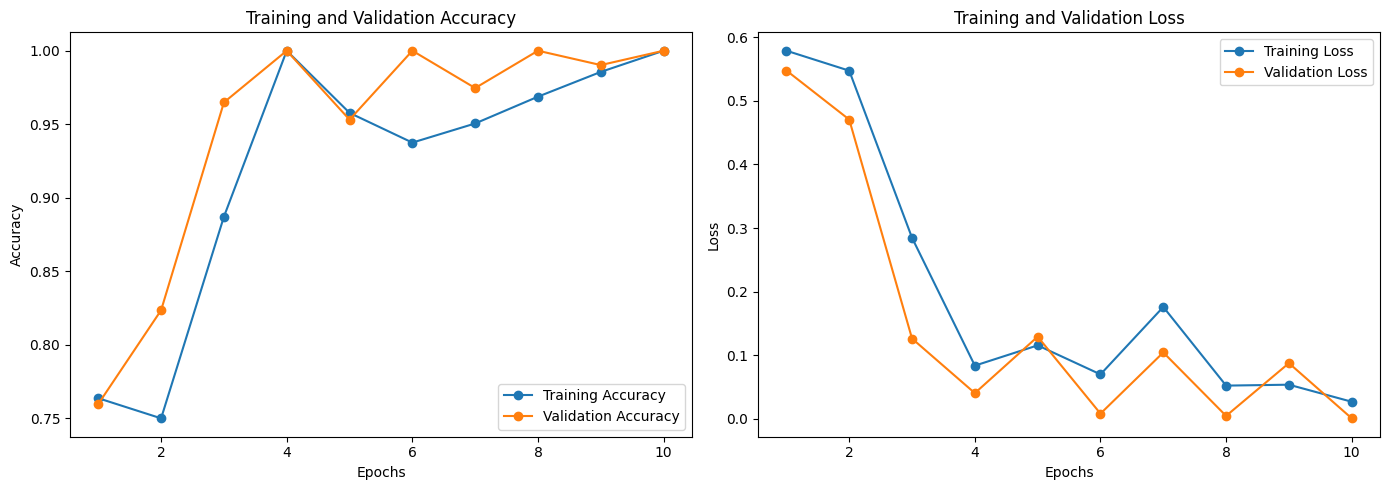

In [7]:
import matplotlib.pyplot as plt

# Fungsi untuk memvisualisasikan akurasi dan loss
def plot_training_history(history):
    # Ekstrak data dari history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot akurasi
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Tampilkan plot
    plt.tight_layout()
    plt.show()

# Panggil fungsi visualisasi
plot_training_history(history)


## **Evaluasi Model**

In [8]:
# Evaluasi pada data validasi
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 492ms/step - accuracy: 0.9940 - loss: 0.0640
Validation Loss: 0.0785
Validation Accuracy: 0.9905


## **Simpan dan Muat Model**

In [31]:
import pickle

with open('kubis_cnn_model.pkl', 'wb') as file:
    pickle.dump(model, file)


## **Prediksi pada Gambar**

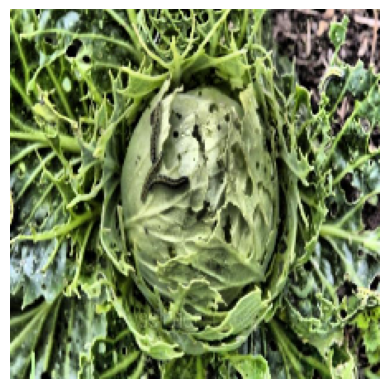

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
Predicted Class: Kubis Tidak Sehat
Confidence: 99.92%


In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Fungsi untuk memuat dan memproses gambar
def preprocess_image(image_path, target_size=(224, 224)):
    # Load gambar
    img = load_img(image_path, target_size=target_size)
    # Tampilkan gambar
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    # Convert gambar ke array
    img_array = img_to_array(img)
    # Normalisasi (rescale pixel values to [0,1])
    img_array = img_array / 255.0
    # Tambahkan dimensi batch (1, 224, 224, 3)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Fungsi untuk memprediksi gambar
def predict_image(image_path, model, class_labels):
    # Preprocess gambar
    processed_image = preprocess_image(image_path)
    # Prediksi kelas
    predictions = model.predict(processed_image)
    predicted_class_index = np.argmax(predictions[0])  # Indeks kelas dengan probabilitas tertinggi
    predicted_class = class_labels[predicted_class_index]
    confidence = predictions[0][predicted_class_index] * 100
    return predicted_class, confidence

# Daftar kelas sesuai training
class_labels = ['Bukan Kubis', 'Kubis Sehat', 'Kubis Tidak Sehat']

# Path ke gambar yang ingin diprediksi
image_path = '/content/drive/MyDrive/Kubis_Final/train/tidak-sehat_jpg.rf.2d4f5c9fb48e2050ec2a6c834af19a9c.jpg'

# Prediksi gambar
predicted_class, confidence = predict_image(image_path, model, class_labels)

# Tampilkan hasil prediksi
print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence:.2f}%")